# Notebook to fit air-LUSI data with relab Apollo spectra 
Work in progress. The end of the file is not currently useful. 

In [1]:
from pathlib import Path
import os
from io import StringIO
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr

from scipy.optimize import curve_fit

import air-LUSI spectra

In [2]:
ds_lunar_spectra = xr.load_dataset("../data/air_lusi_spectra.nc")

# Get lunar soil data
Lunar soil is from `https://sites.brown.edu/relab/lscc/`
Check if 19 files are in directory `localcache/`, but if not download the relab files. These are in the .gitignore so that we are not hosting them on our site. Download from the Brown site can be a little finicky. Also note that the files have a few characters that the Python file functions don't like in the headers, and these have to be manually removed. When the files are read in, it's also a bit unusual the way we do it, because polars was not interpreting correctly, but opening a file and passing the string to a `StringIO` object works just fine. 

In [3]:
remote_files = [
    "https://sites.brown.edu/relab/files/2022/02/10084Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/12001Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/12030Kdata.txt",
    "https://bpb-us-w2.wpmucdn.com/sites.brown.edu/dist/b/323/files/2022/02/15041Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/15071Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/70181Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/71061Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/71501Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/79221Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/14141Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/14163Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/14259Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/14260Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/61141Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/61221Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/62231Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/64801Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/67461Kdata.txt",
    "https://sites.brown.edu/relab/files/2022/02/67481Kdata.txt",
]
data_files = [path for path in Path("../localcache/").rglob("*.txt")]
print(f"Found {len(data_files)} files")
if len(data_files) != 19:
    print("Attempting to get more data files")
    for file in remote_files:
        if file.split("/")[-1] not in [file.name for file in data_files]:
            urlretrieve(file, "../localcache/" + file.split("/")[-1])
    data_files = [path for path in Path("../localcache/").rglob("*.txt")]
    print(f"Found {len(data_files)} files")

Found 19 files


In [4]:
spectra = []
for file in data_files:
    with open(file, "r") as f:
        s = f.read(-1)
        s = StringIO(s)
    spectra += [pl.read_csv(s, separator="\t")]

In [5]:
data_cols = [col for spectrum in spectra for col in spectrum.columns if "<45" in col]

Text(0.5, 1.0, '19 Relab spectra from https://sites.brown.edu/relab/lscc/')

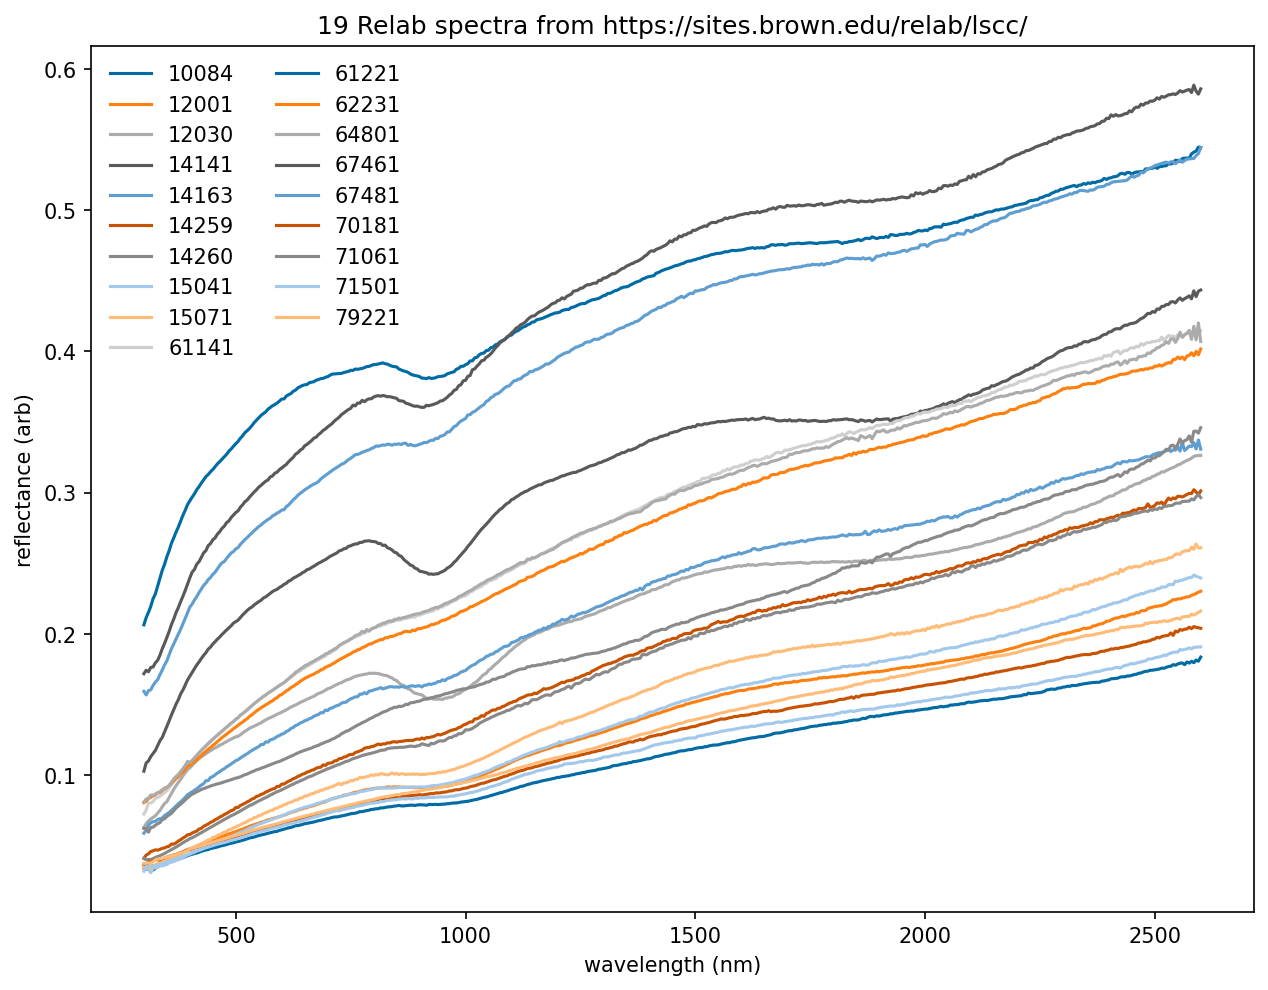

In [6]:
fig, ax = plt.subplots(1)

for col, spectrum in zip(data_cols, spectra):
    ax.plot(spectrum["Wavelength"], spectrum.select(col), label=col[:5])
    ax.set_xlabel("wavelength (nm)")
    ax.set_ylabel("reflectance (arb)")
    # ax.set_xlim(350,1050)
    # ax.legend()
ax.legend(ncols=2)
ax.set_title("19 Relab spectra from https://sites.brown.edu/relab/lscc/")

Validate that wavelengths are the same below 1100 nm in every spectrum

In [7]:
for n in range(19):
    assert all(
        spectra[n]["Wavelength"].to_numpy()[spectra[n]["Wavelength"] < 1101]
        == spectra[0]["Wavelength"].to_numpy()[spectra[0]["Wavelength"] < 1101]
    )

Create a dataarray with relab spectra

In [8]:
useful_data = spectra[0]["Wavelength"] < 3000  # 1101
wl = spectra[0]["Wavelength"].to_numpy()[useful_data]
spectral_data = np.array(
    [spectrum[col].to_numpy()[useful_data] for col, spectrum in zip(data_cols, spectra)]
)
da_relab = xr.DataArray(
    data=spectral_data,
    dims=["Spectrum_ID", "Wavelength"],
    coords=dict(Spectrum_ID=[col[:5] for col in data_cols], Wavelength=wl),
)

# Fit the air-LUSI reflectances
These are not disk reflectances, but raw physical reflectances

In [9]:
da_lunar_irradiance = ds_lunar_spectra.Irradiance.dropna("Wavelength")
wl_fit = da_lunar_irradiance.Wavelength
da_lunar_reflectance = ds_lunar_spectra.Lunar_Reflectance.sel(Wavelength=wl_fit)
da_relab_regrid = da_relab.interp(Wavelength=da_lunar_irradiance.Wavelength)
da_relab_norm = da_relab_regrid / (
    ((da_relab_regrid**2).sum(dim="Wavelength")) ** (1 / 2)
)
fit_coefficients = da_lunar_reflectance.values @ np.linalg.pinv(
    da_relab_norm, rcond=5e-15
)
best_fit = fit_coefficients @ da_relab_norm.values

Text(0.5, 0, 'wavelength (nm)')

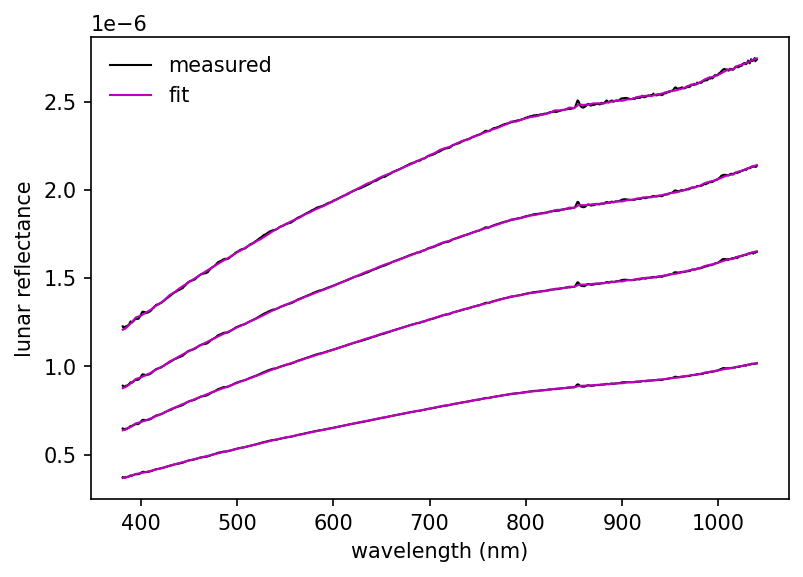

In [10]:
fig, ax = plt.subplots(1)

h0 = ax.plot(
    wl_fit, da_lunar_reflectance.values.T, linewidth=1, color="k", label="measured"
)
h1 = ax.plot(wl_fit, best_fit.T, linewidth=1, color="m", label="fit")
ax.legend(handles=[h0[0], h1[1]])
fig.set_size_inches(6, 4)
ax.set_ylabel("lunar reflectance")
ax.set_xlabel("wavelength (nm)")

Text(0.5, 0, 'wavelength (nm)')

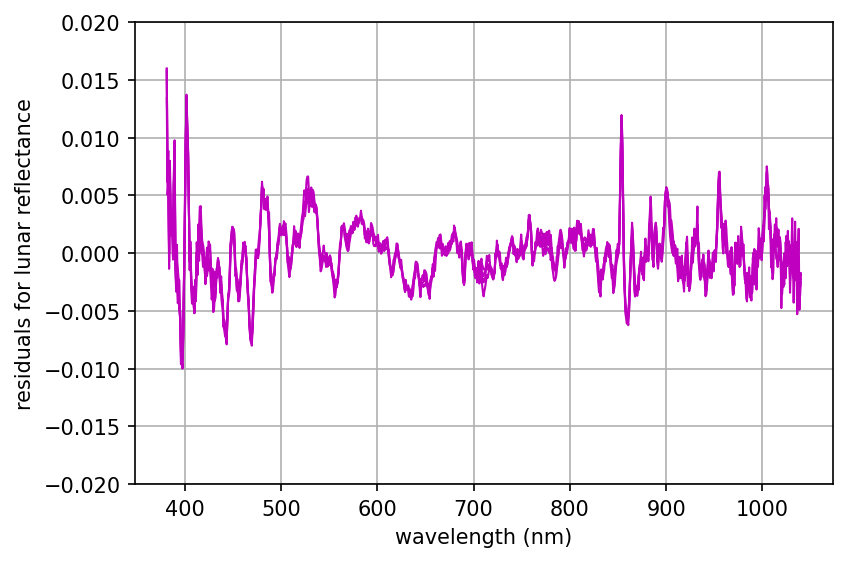

In [11]:
fig, ax = plt.subplots(1, sharex=True)
fractional_residuals = (
    0 + (da_lunar_reflectance.values.T - best_fit.T) / da_lunar_reflectance.values.T
)
h0 = ax.plot(wl_fit, fractional_residuals, linewidth=1, color="m", label="residuals")
ax.grid()
# h1 = ax.plot(wl_fit,best_fit.T,linewidth=1,color="m",label="fit")
# ax.legend(handles=[h0[0],h1[1]])
fig.set_size_inches(6, 4)
# ax.set_xlim(750,780)
ax.set_ylim(-0.02, 0.02)
ax.set_ylabel("residuals for lunar reflectance")
ax.set_xlabel("wavelength (nm)")

Note the absence of an Excursion in the residuals at the Lyman Alpha line

## Residuals by flight

Text(0.5, 23.083333333333314, 'wavelength (nm)')

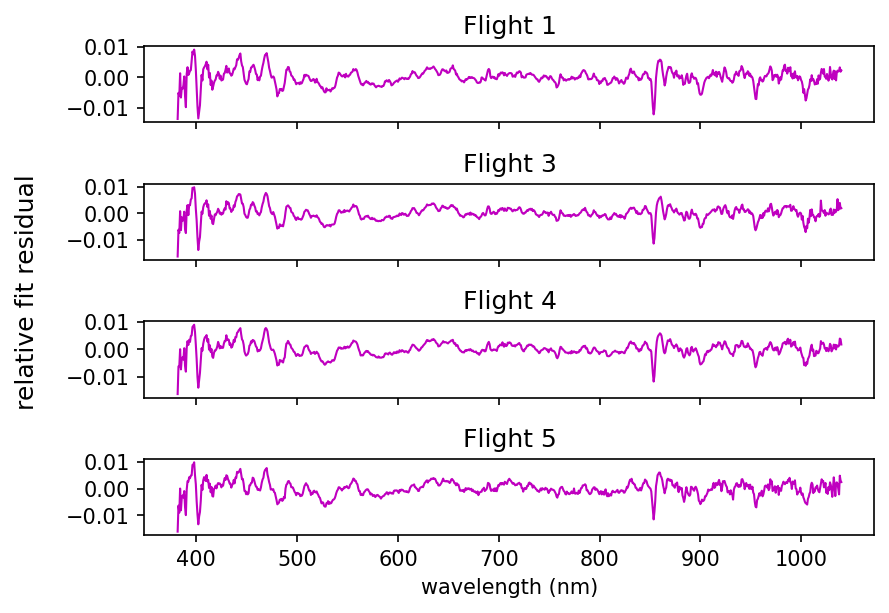

In [12]:
fig, axs = plt.subplots(4, sharex=True)
flights = [1, 3, 4, 5]
for n, ax in enumerate(axs):
    # ax.plot(wl_fit,da_lunar_reflectance.values.T,linewidth=3,color="k")
    ax.plot(
        wl_fit,
        (best_fit[n, :] - da_lunar_reflectance.values[n, :]) / best_fit[n, :],
        linewidth=1,
        color="m",
    )
    ax.set_title(f"Flight {flights[n]}")
fig.set_size_inches(6, 4)
fig.supylabel("relative fit residual")

fig.tight_layout()
ax.set_xlabel("wavelength (nm)")

# Extrapolation
We received the question of whether it's possible to extrapolate to infrared wavelengths using our data and the Apollo Spectra. The answer is that it is possible, though unclear if it's advisable! There are no meaningful error bars that can be assigned to these data. A fit is done here. 

In [13]:
full_spectrum_fit = (
    fit_coefficients
    @ (da_relab / (((da_relab_regrid**2).sum(dim="Wavelength")) ** (1 / 2))).values
)

In [14]:
da_relab.Wavelength

<xarray.DataArray 'Wavelength' (Wavelength: 461)> Size: 4kB
array([ 300.,  305.,  310., ..., 2590., 2595., 2600.])
Coordinates:
  * Wavelength  (Wavelength) float64 4kB 300.0 305.0 310.0 ... 2.595e+03 2.6e+03

Text(0.5, 0, 'wavelength (nm)')

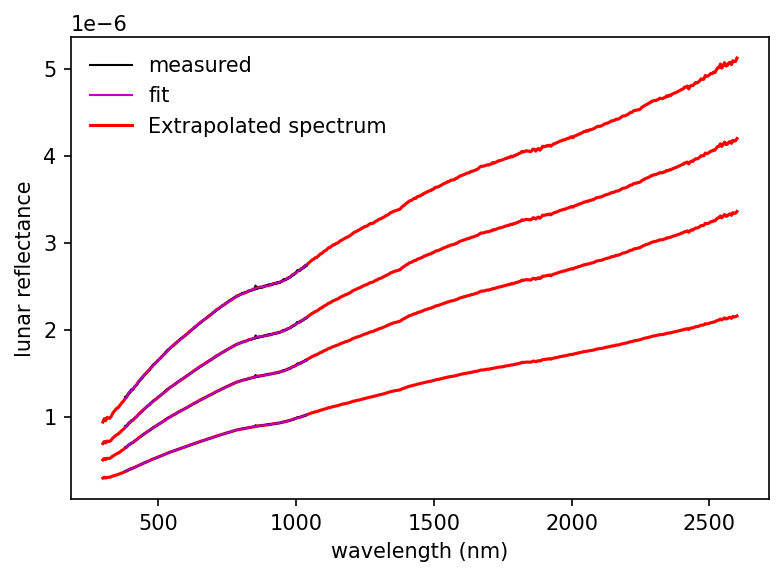

In [15]:
fig, ax = plt.subplots(1)
h2 = ax.plot(
    da_relab.Wavelength, full_spectrum_fit.T, color="r", label="Extrapolated spectrum"
)

h0 = ax.plot(
    wl_fit, da_lunar_reflectance.values.T, linewidth=1, color="k", label="measured"
)
h1 = ax.plot(wl_fit, best_fit.T, linewidth=1, color="m", label="fit")
ax.legend(handles=[h0[0], h1[1], h2[0]])
fig.set_size_inches(6, 4)
ax.set_ylabel("lunar reflectance")
ax.set_xlabel("wavelength (nm)")

# Freeform calculations
Below documentation will be improved. Here we're looking at dimensionality reduction of the data. Everything below is a bit rough. 

1


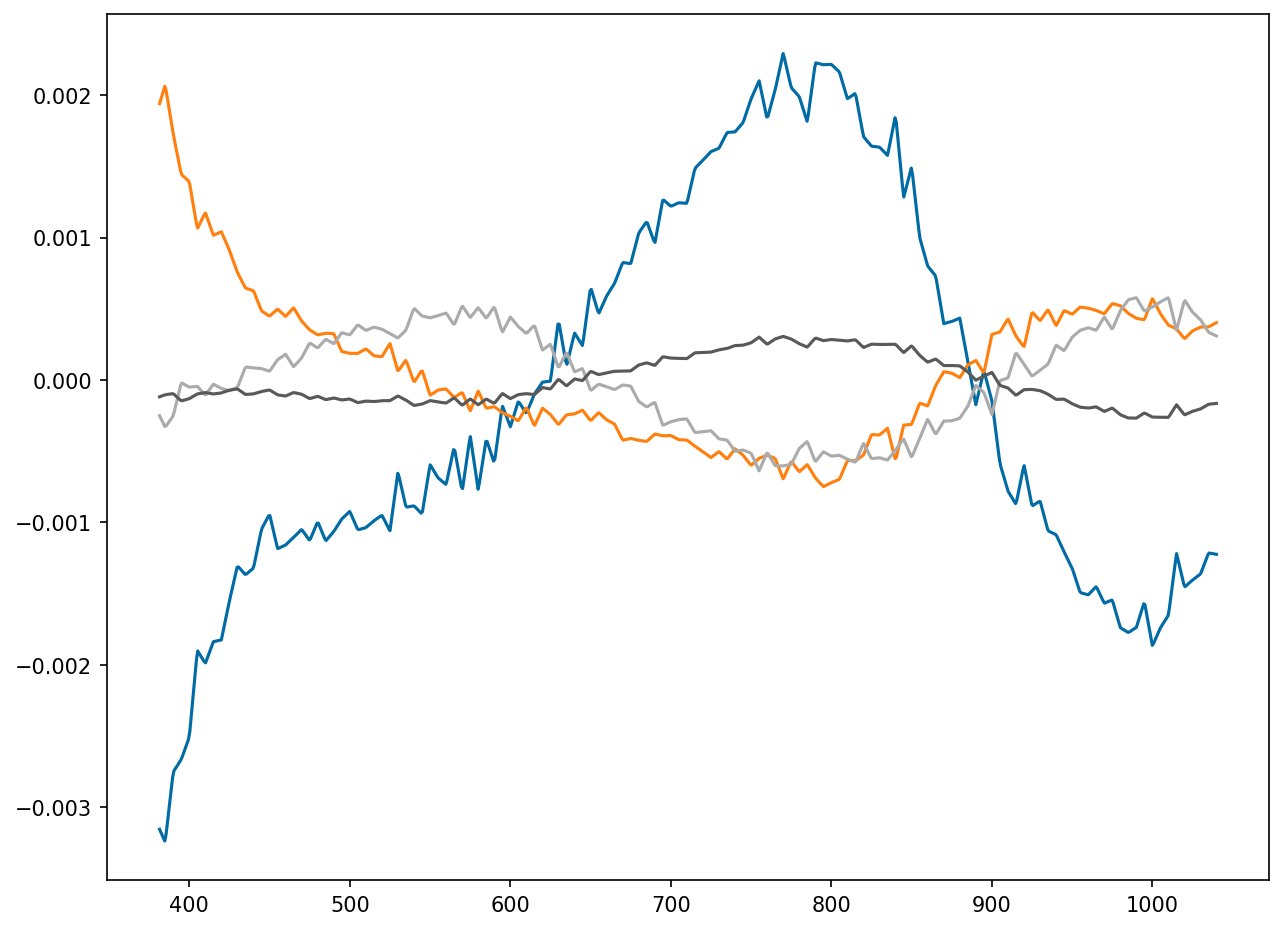

In [16]:
u, s, vt = np.linalg.svd(best_fit.T)


def fit_first_n(x, n):
    vec = (u[:, 0] @ x) * u[:, 0].reshape(-1, 1)
    for m in range(1, n):
        print(m)
        coeff = u[:, m] @ x
        vec += coeff * u[:, m].reshape(-1, 1)
    return vec


x = best_fit.T
plt.plot(wl_fit, (fit_first_n(x, 2) - x) / x)

,0,1
0,2.351725,193.674231
1,-18.985948,-1522.957694
2,68.078377,5323.210221
3,-142.290649,-10894.374831
4,192.003890,14456.406907
5,-174.398484,-12995.632328
6,107.710759,8014.970582
7,-44.546021,-3348.810737
8,11.774171,907.236595
9,-1.790797,-143.924218


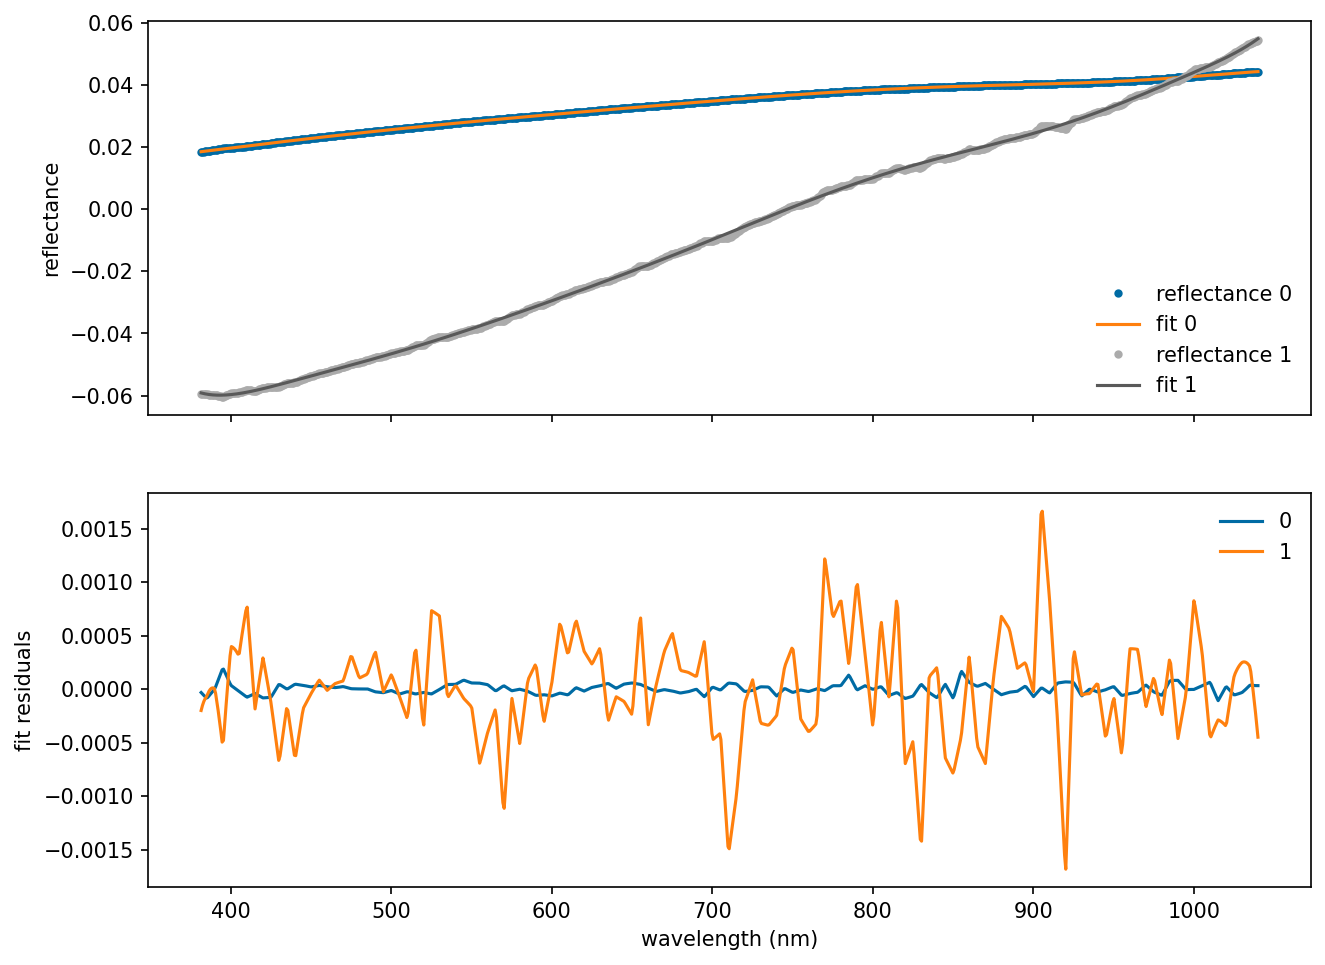

In [17]:
coeffs = []
divisor = 500
fig, ax = plt.subplots(2, sharex=True)
for n in range(2):
    popt = np.polyfit(wl_fit / divisor, -u[:, n], 10)
    ax[0].plot(wl_fit, -u[:, n], ".", label=f"reflectance {n}")
    ax[0].plot(wl_fit, np.polyval(popt, wl_fit / divisor), label=f"fit {n}")
    ax[1].plot(wl_fit, (-u[:, n] - np.polyval(popt, wl_fit / divisor)), label=f"{n}")
    coeffs += [popt]
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel("wavelength (nm)")
ax[0].set_ylabel("reflectance")
ax[1].set_ylabel("fit residuals")
import pandas as pd

pd.DataFrame(np.array(coeffs)[:, -1:0:-1]).T  # .to_csv("basis_reflectance.csv")

normalize relab spectra

Text(0.5, 23.083333333333314, 'wavelength (nm)')

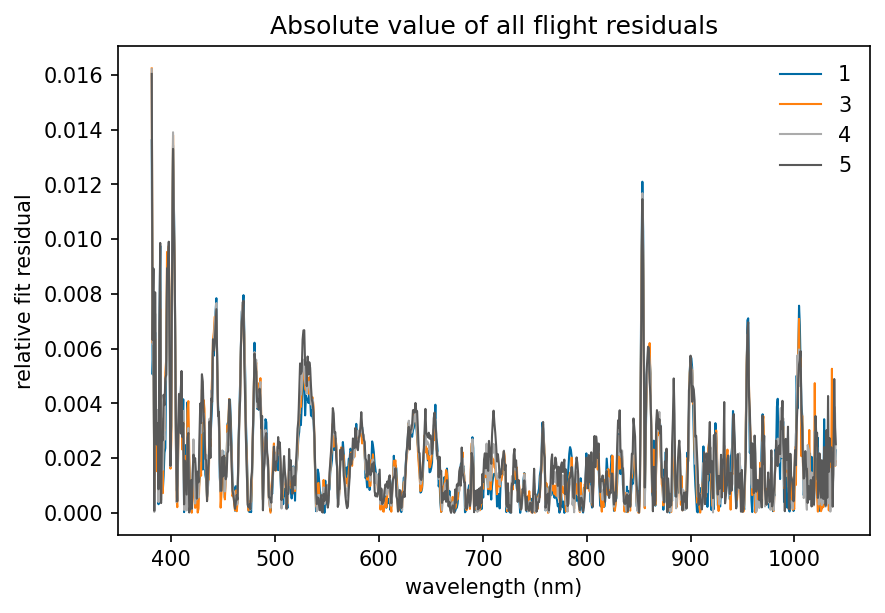

In [18]:
fig, ax = plt.subplots(1, sharex=True)
flights = [1, 3, 4, 5]
for n, flight in enumerate(flights):
    # ax.plot(wl_fit,da_lunar_reflectance.values.T,linewidth=3,color="k")
    ax.plot(
        wl_fit,
        np.abs((best_fit[n, :] - da_lunar_reflectance.values[n, :]) / best_fit[n, :]),
        linewidth=1,
        label=flight,
    )
ax.set_title(f"Absolute value of all flight residuals")
fig.set_size_inches(6, 4)
ax.set_ylabel("relative fit residual")
ax.legend()
fig.tight_layout()
ax.set_xlabel("wavelength (nm)")

In [19]:
da_relab_regrid.to_netcdf("../data/relab_spectra/relab_data.nc")

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\smaxwell\\GitRepos\\air-lusi\\data\\relab_spectra\\relab_data.nc'

In [ ]:
u, s, vt = np.linalg.svd(da_relab_norm.values.T, full_matrices=False)

In [ ]:
s

In [ ]:
fig, ax = plt.subplots(2)
# da_relab_norm.plot.line(x="Wavelength",ax=ax[0])
ax[1].plot(s, ".")
ax[1].set_yscale("symlog", linthresh=5e-3)
ax[1].set_ylim([0, 10])
for n in range(6):
    ax[0].plot(wl_fit, u[:, n], label=f"component {n}")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 0.9))
ax[0].set_title(
    "First principal components of the RELAB spectra\n(left singular vectors of normalized spectrum matrix)"
)
ax[0].set_xlabel("wavelength (nm)")
ax[1].set_xlabel("component number")
ax[1].set_ylabel("singular value")
fig.set_size_inches(6, 4)

In [ ]:
fig, ax = plt.subplots(3, 2)
ax = ax.T.flatten()
# da_relab_norm.plot.line(x="Wavelength",ax=ax[0])
# ax[1].plot(s,'.')
# ax[1].set_yscale("symlog",linthresh=5e-3)
# ax[1].set_ylim([0,10])
for n in range(6):
    if n == 0:
        si = -1
    else:
        si = 1
    ax[n].plot(wl_fit, si * u[:, n], label=f"component {n}")
# ax[0].legend(loc="upper left",bbox_to_anchor=(1,.9))
# ax[0].set_title("First principal components of the RELAB spectra\n(left singular vectors of normalized spectrum matrix)")
# ax[0].set_xlabel("wavelength (nm)")
# ax[1].set_xlabel("component number")
# ax[1].set_ylabel("singular value")
# fig.set_size_inches(6,4)

In [ ]:
s

In [ ]:
# def fit_by_num_components(n):
#     fit_coefficients = da_lunar_reflectance.values @ np.linalg.pinv(da_relab_norm,rcond=s[n] + 5e-15)
#     print(s > s[n] + 5e-15)
#     return fit_coefficients @ da_relab_norm.values


def fit_by_num_components(n):
    inverse_matrix = (1 / s[0]) * u[:, 0].reshape([1, -1]) * vt[0, :].reshape([-1, 1])
    for m in range(n - 1):
        # print(m)
        inverse_matrix += (
            (1 / s[m + 1])
            * u[:, m + 1].reshape([1, -1])
            * vt[m + 1, :].reshape([-1, 1])
        )
    fit_coefficients = da_lunar_reflectance.values @ inverse_matrix.T
    return fit_coefficients @ da_relab_norm.values


def plot_by_num_components():
    fig, ax = plt.subplots(1)
    for n in range(6, -1, -1):
        # ax.plot(wl_fit,da_lunar_reflectance.values.T,linewidth=3,color="k")
        best_fit = fit_by_num_components(n + 1)
        ax.plot(
            wl_fit,
            (best_fit[0, :] - da_lunar_reflectance.values[0, :]) / best_fit[0, :],
            linewidth=1,
            label=f"{n+1} components",
        )
    fig.set_size_inches(6, 4)
    # fig.supylabel("relative fit residual")

    fig.tight_layout()
    ax.set_xlabel("wavelength (nm)")
    ax.legend(ncols=2)
    ax.set_ylabel("relative residual")


plot_by_num_components()

In [ ]:
s

In [ ]:
u_coeffs = s * (vt @ fit_coefficients[0, :])
fig, ax = plt.subplots(1)
for n in range(10):
    plt.plot(wl_fit, u[:, n] * u_coeffs[n], label=n)
ax.legend(ncols=2)
fig.set_size_inches(5, 4)
ax.set_yscale("symlog", linthresh=1e-2)

# Analysis of full range

In [ ]:
wl

In [ ]:
spectra

In [ ]:
useful_data

In [ ]:
useful_data = spectra[0]["Wavelength"] < 2700
wl = spectra[0]["Wavelength"].to_numpy()[useful_data]
spectral_data = np.array(
    [spectrum[col].to_numpy()[useful_data] for col, spectrum in zip(data_cols, spectra)]
)
da_relab = xr.DataArray(
    data=spectral_data,
    dims=["Spectrum_ID", "Wavelength"],
    coords=dict(Spectrum_ID=[col[:5] for col in data_cols], Wavelength=wl),
)
da_relab

In [ ]:
da_relab_norm = da_relab / np.sqrt((da_relab**2).sum(dim="Spectrum_ID"))

In [ ]:
da_relab_norm

In [ ]:
u, s, vt = np.linalg.svd(da_relab_norm.T)

In [ ]:
fig, ax = plt.subplots(2)
# da_relab_norm.plot.line(x="Wavelength",ax=ax[0])
ax[1].plot(s, ".")
ax[1].set_yscale("symlog", linthresh=5e-3)
# ax[1].set_ylim([0,10])
for n in range(8):
    ax[0].plot(da_relab_norm.Wavelength, u[:, n], label=f"component {n}")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 0.9))
ax[0].set_title(
    "First principal components of the RELAB spectra\n(left singular vectors of normalized spectrum matrix)"
)
ax[0].set_xlabel("wavelength (nm)")
ax[1].set_xlabel("component number")
ax[1].set_ylabel("singular value")
fig.set_size_inches(10, 8)